# Unrolling neural network training

In [84]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float32)

import warnings
warnings.filterwarnings("ignore")


## Toy case models and datasets

In [85]:
boston = load_boston()
X = boston.data
y = boston.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y_train to match model output shape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape y_test to match model output shape

In [88]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay = 5e-4)
criterion = nn.MSELoss()

### Simple training loop 

In [87]:
train_losses = []

for epoch in range(100):
    # Forward pass
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 108.9392
Epoch [20/100], Loss: 43.4876
Epoch [30/100], Loss: 24.4725
Epoch [40/100], Loss: 18.0850
Epoch [50/100], Loss: 14.4142
Epoch [60/100], Loss: 12.0501
Epoch [70/100], Loss: 10.4739
Epoch [80/100], Loss: 9.5392
Epoch [90/100], Loss: 8.7902
Epoch [100/100], Loss: 8.1955
Test Loss: 12.1529


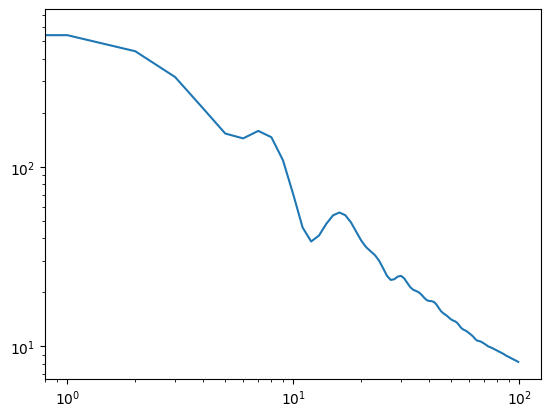

In [6]:
plt.loglog(train_losses)

### SCANTRA - DeepUnrolling SCA for Neural networks TRAining

Let's try to define a surrogate loss using a general purpose second order approximations and the gradient of the feedforward network. 

In [169]:
class SCANTRALayer(nn.Module):
    def __init__(self, model, lambda_ = 0.1, tau = 1, gamma = 0.9):
        super().__init__()

        # Initialization of the learnable parameters
        self.lambda_ = nn.Parameter(torch.ones(1)*lambda_, requires_grad = True)
        self.tau = nn.Parameter(torch.ones(1)*tau, requires_grad = True)
        self.gamma = gamma
        
        self.B = []
        for _, p in model.named_parameters():
            self.B.append(nn.Parameter(torch.randn(p.shape[0]), requires_grad = True))

        self.B = nn.ParameterList(self.B + [self.lambda_, self.tau])


    def forward(self, model):
        for i, (_, p) in enumerate(model.named_parameters()):
            K = p.grad
            # Local optimization step
            if len(p.shape) == 1:
                I = torch.ones(self.B[i].shape[0])
                H = self.B[i]**2 + self.tau*I
                M = 1/((2*self.lambda_ + self.tau)*I + H)
                
            else:
                I = self.tau*torch.eye(self.B[i].shape[0])
                H = torch.outer(self.B[i],self.B[i]) + self.tau*I
                M = torch.linalg.inv((2*self.lambda_ + self.tau)*I + H)

            w_hat = M @ (H @ p - K)
            #p_0 = p
            with torch.no_grad():
                 p.copy_(p + self.gamma*(w_hat - p))
            #print(torch.linalg.norm(p - p_0))

In [193]:
class SCANTRANet(nn.Module):
    def __init__(self, model, T = 10, lambda_ = 0.1, tau = 25, gamma = 0.8):
        super(SCANTRANet, self).__init__()
        
        # Number of iterations <-> number of layers
        self.T = T
        
        # Initialization of the learnable parameters
        self.lambda_0 = torch.ones(T)*lambda_
        self.tau_0 = torch.ones(T)*tau
        self.gamma_0 = torch.ones(T)*gamma

        for i in range(self.T):
            self.gamma_0[i] *= 0.99**i
            
        # Defining the layers
        self.SCANTRA_layers = nn.ModuleList([SCANTRALayer(model,
                                                          self.lambda_0[i], 
                                                          self.tau_0[i], 
                                                          self.gamma_0[i]
                                                          ) for i in range(self.T)])
        
        # Optimizer of the neural optimizer
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=5e-3, weight_decay = 5e-4)
        
    def step(self, model, epoch):
        self.SCANTRA_layers[epoch].forward(model)
        self.source = model
    
    def learn(self, model, criterion, X_train_tensor, y_train_tensor):
        # Compute loss
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Zero gradients for optimizer parameters
        self.zero_grad()

        # Compute gradients of loss with respect to optimizer parameters
        loss.backward(retain_graph=True)

        # Update optimizer parameters
        self.optimizer.step()        

In [194]:
optimizer = SCANTRANet(model, T = 1000)

In [195]:
optimizer.parameters

<bound method Module.parameters of SCANTRANet(
  (SCANTRA_layers): ModuleList(
    (0): SCANTRALayer(
      (B): ParameterList(
          (0): Parameter containing: [torch.float32 of size 30]
          (1): Parameter containing: [torch.float32 of size 30]
          (2): Parameter containing: [torch.float32 of size 1]
          (3): Parameter containing: [torch.float32 of size 1]
          (4): Parameter containing: [torch.float32 of size 1]
          (5): Parameter containing: [torch.float32 of size 1]
      )
    )
    (1): SCANTRALayer(
      (B): ParameterList(
          (0): Parameter containing: [torch.float32 of size 30]
          (1): Parameter containing: [torch.float32 of size 30]
          (2): Parameter containing: [torch.float32 of size 1]
          (3): Parameter containing: [torch.float32 of size 1]
          (4): Parameter containing: [torch.float32 of size 1]
          (5): Parameter containing: [torch.float32 of size 1]
      )
    )
    (2): SCANTRALayer(
      (B): P

The problem is: how do I train at the same time the network and the optimizer? 

In [196]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [197]:
train_losses = []

for epoch in range(1000):
    # Forward pass
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    
    # Our beautiful neural optimizer
    optimizer.step(model, epoch)
    optimizer.learn(model, criterion, X_train_tensor, y_train_tensor)
    #optimizer.transfer(model)
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

    # Evaluate the model on the test set
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 507.7179
Test Loss: 461.6483
Test Loss: 438.0277
Test Loss: 425.6703
Test Loss: 419.0534
Test Loss: 415.3096
Test Loss: 413.2524
Test Loss: 412.1137
Test Loss: 411.4901
Epoch [10/100], Loss: 474.8581
Test Loss: 411.1448
Test Loss: 410.9307
Test Loss: 410.8062
Test Loss: 410.7306
Test Loss: 410.6889
Test Loss: 410.6635
Test Loss: 410.6472
Test Loss: nan
Test Loss: nan
Test Loss: nan
Epoch [20/100], Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Epoch [30/100], Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Epoch [40/100], Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Epoch [50/100], Loss: nan
Test Loss: nan
Test Loss: nan
Test Loss: nan
Test 

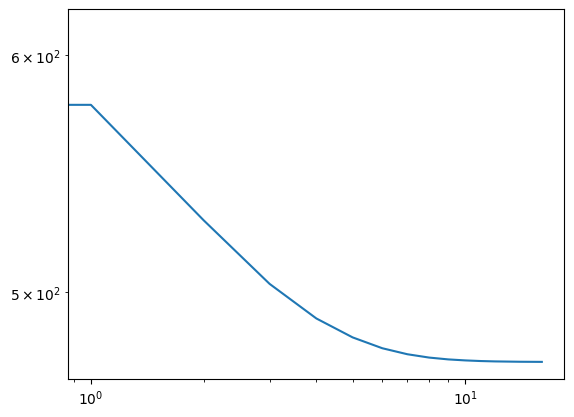

In [201]:
plt.loglog(train_losses)

In [199]:
len(train_losses)

1000

In [200]:
train_losses

[613.648193359375,
 577.5039672851562,
 528.46142578125,
 503.2480163574219,
 490.03680419921875,
 482.95648193359375,
 478.9486083984375,
 476.7456359863281,
 475.5260009765625,
 474.8581237792969,
 474.4882507324219,
 474.2588806152344,
 474.12548828125,
 474.04443359375,
 473.9998474121094,
 473.9726867675781,
 473.9551696777344,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,